In [1]:
from typing import List, Tuple
import pickle as pic
from collections import Counter
from itertools import product

import numpy as np
#import cupy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
import log_parser

In [3]:
KEYROUND_WIDTH_4 = 60
KEYROUND_WIDTH_B4 = 98

KEY_WIDTH_4 = 256
KEY_WIDTH_B4 = 512

BLOCK_WIDTH_4 = 5
BLOCK_WIDTH_B4 = 7

In [4]:
HW = [bin(n).count("1") for n in range(0, 16)]

In [5]:
def corr_coef(hypotheses, traces):
    #Initialize arrays & variables to zero
    num_traces, num_points = traces.shape
    sumnum = np.zeros(num_points)
    sumden1 = np.zeros(num_points)
    sumden2 = np.zeros(num_points)

    #Mean of hypotheses
    h_mean = np.mean(hypotheses, dtype=np.float64)

    #Mean of all points in trace
    t_mean = np.mean(traces, axis=0, dtype=np.float64)

    #For each trace, do the following
    for t_idx in range(num_traces):
        h_diff = (hypotheses[t_idx] - h_mean)
        t_diff = traces[t_idx, :] - t_mean

        sumnum = sumnum + (h_diff * t_diff)
        sumden1 = sumden1 + h_diff * h_diff 
        sumden2 = sumden2 + t_diff * t_diff

    correlation = sumnum / np.sqrt(sumden1 * sumden2)

    return correlation

In [6]:
def corr_coef_vectorized(hypotheses, traces):
    h_mean = np.mean(hypotheses)
    t_mean = np.mean(traces, axis=0)
    h_diff, t_diff = hypotheses - h_mean, traces - t_mean

    r_num = np.sum(h_diff[:, None] * t_diff, axis=0)
    r_den = np.sqrt(np.sum(h_diff * h_diff, axis=0) * np.sum(t_diff * t_diff, axis=0))
    r = r_num / r_den
    r = np.clip(r, -1.0, 1.0)
    return r

# Elisabeth-b4 - Filter block

## Attacking S-box S1

In [99]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.log"

In [100]:
traces_dict = sio.loadmat(traces_path)

traces = np.empty((len([k for k in traces_dict.keys() if 'data' in k]), 60000))
for i, k in enumerate([k for k in traces_dict.keys() if 'data' in k]):
    traces[i] = traces_dict[k][0, 0][4][:, 0]

num_traces = np.shape(traces)[0]
num_points = np.shape(traces)[1]

In [101]:
real_keys = log_parser.parse(key_path)

real_keys = np.array([key[0][0] for key in real_keys])

### Check our data

In [106]:
NR_PLOT = 5

C:\Users\ppace\AppData\Local\Temp\ipykernel_12796\3963726462.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


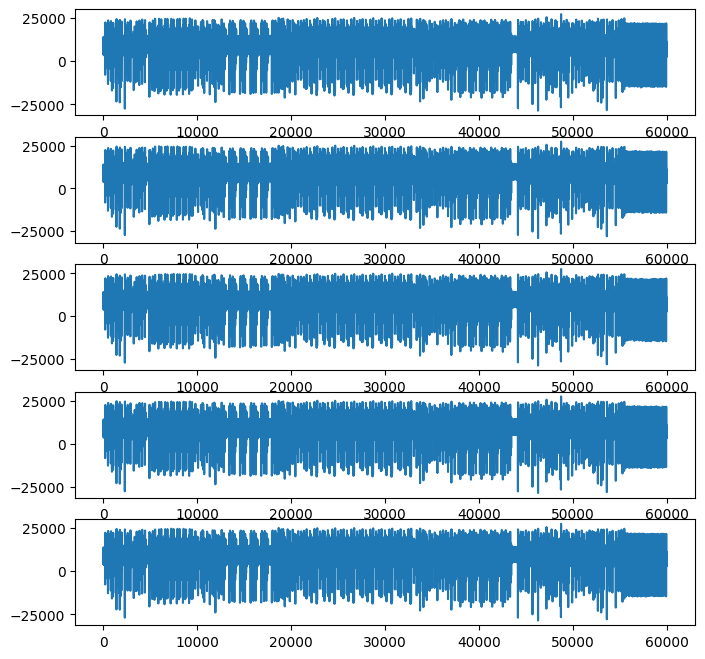

In [107]:
fig, axs = plt.subplots(NR_PLOT, figsize=(8, 8))
for ax, trace in zip(axs, traces[:NR_PLOT]):
    ax.plot(trace)
fig.show()

### Find the timepoint where S1 is executed

In [12]:
s1 = [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A]

def hypothesis_s1(x1: int, x2: int) -> int:
    return HW[s1[(x1 + x2) % 16]]


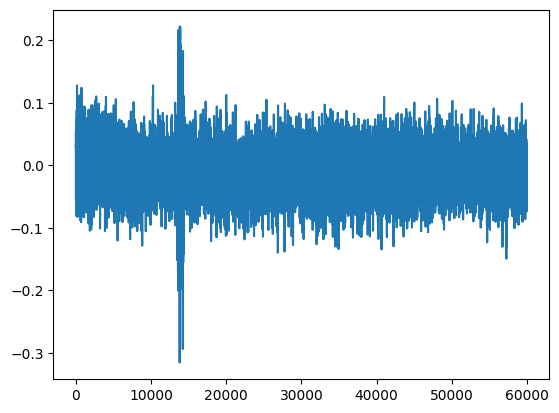

In [13]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))

Wow !!!

(13500.0, 14500.0)

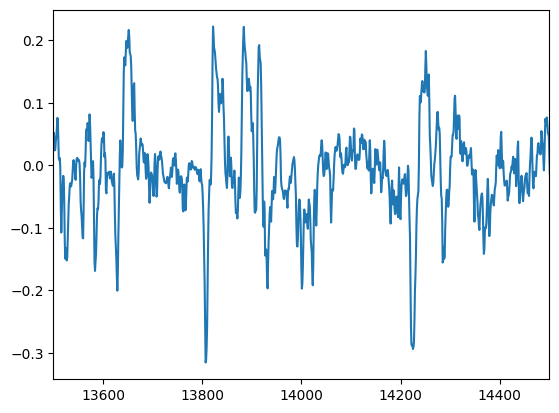

In [14]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))
plt.xlim([13500, 14500])

## Attacking the filter S-boxes

### Finding their locations in time

In [7]:
s_boxes_b4 = [
    [0x0A, 0x06, 0x0B, 0x08, 0x04, 0x09, 0x08, 0x0C, 0x06, 0x0A, 0x05, 0x08, 0x0C, 0x07, 0x08, 0x04],
    [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A],
    [0x0D, 0x0E, 0x0E, 0x02, 0x03, 0x09, 0x03, 0x05, 0x03, 0x02, 0x02, 0x0E, 0x0D, 0x07, 0x0D, 0x0B],
    [0x02, 0x09, 0x08, 0x0B, 0x0D, 0x08, 0x01, 0x07, 0x0E, 0x07, 0x08, 0x05, 0x03, 0x08, 0x0F, 0x09],
    [0x0B, 0x03, 0x0F, 0x09, 0x00, 0x00, 0x0C, 0x00, 0x05, 0x0D, 0x01, 0x07, 0x10, 0x10, 0x04, 0x10],
    [0x0F, 0x0C, 0x01, 0x0F, 0x0E, 0x01, 0x06, 0x0C, 0x01, 0x04, 0x0F, 0x01, 0x02, 0x0F, 0x0A, 0x04],
    [0x06, 0x0E, 0x0D, 0x00, 0x07, 0x0E, 0x0C, 0x03, 0x0A, 0x02, 0x03, 0x10, 0x09, 0x02, 0x04, 0x0D],
    [0x0C, 0x00, 0x04, 0x01, 0x0F, 0x0B, 0x04, 0x00, 0x04, 0x10, 0x0C, 0x0F, 0x01, 0x05, 0x0C, 0x10],
    [0x0B, 0x00, 0x0F, 0x0A, 0x09, 0x0B, 0x09, 0x02, 0x05, 0x10, 0x01, 0x06, 0x07, 0x05, 0x07, 0x0E],
    [0x0D, 0x03, 0x0B, 0x0B, 0x08, 0x09, 0x08, 0x0C, 0x03, 0x0D, 0x05, 0x05, 0x08, 0x07, 0x08, 0x04],
    [0x0A, 0x02, 0x08, 0x04, 0x0F, 0x0B, 0x06, 0x04, 0x06, 0x0E, 0x08, 0x0C, 0x01, 0x05, 0x0A, 0x0C],
    [0x0D, 0x08, 0x0E, 0x08, 0x02, 0x05, 0x03, 0x0B, 0x03, 0x08, 0x02, 0x08, 0x0E, 0x0B, 0x0D, 0x05],
    [0x0D, 0x0F, 0x02, 0x05, 0x05, 0x0F, 0x09, 0x0B, 0x03, 0x01, 0x0E, 0x0B, 0x0B, 0x01, 0x07, 0x05],
    [0x0D, 0x00, 0x0A, 0x0A, 0x06, 0x07, 0x03, 0x0E, 0x03, 0x10, 0x06, 0x06, 0x0A, 0x09, 0x0D, 0x02],
    [0x00, 0x04, 0x07, 0x00, 0x09, 0x04, 0x0C, 0x00, 0x10, 0x0C, 0x09, 0x10, 0x07, 0x0C, 0x04, 0x10],
    [0x04, 0x0B, 0x06, 0x03, 0x0F, 0x06, 0x0C, 0x02, 0x0C, 0x05, 0x0A, 0x0D, 0x01, 0x0A, 0x04, 0x0E],
    [0x03, 0x0C, 0x01, 0x08, 0x08, 0x0F, 0x0D, 0x0F, 0x0D, 0x04, 0x0F, 0x08, 0x08, 0x01, 0x03, 0x01],
    [0x0B, 0x03, 0x02, 0x0C, 0x03, 0x08, 0x04, 0x02, 0x05, 0x0D, 0x0E, 0x04, 0x0D, 0x08, 0x0C, 0x0E]
]

s_boxes_b4 = [[s_ & 0x0F for s_ in box] for box in s_boxes_b4]

In [8]:
from ctypes import *

class aes_ctx(Structure):
    _fields_ = [
        ("RoundKey", c_uint8 * 176),
        ("Iv", c_uint8 * 16)
    ]

class ecrypt_ctx(Structure):
    _fields_ = [
        ("input", c_uint32 * 16)
    ]

class rng(Structure):
    pass

rng._fields_ = [
    ("indices", c_uint16 * 512),
    ("whitening", c_uint8 * 98),
    ("mode", c_int),
    ("gen_rand_uniform", CFUNCTYPE(c_uint8, POINTER(rng), POINTER(c_uint8))),
    ("copy", CFUNCTYPE(None, POINTER(rng), POINTER(rng))),
    ("next_elem", CFUNCTYPE(None, POINTER(rng)))
]

class rng_aes(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", aes_ctx),
        ("ctr", c_uint8 * 16),
        ("batch_idx", c_size_t)
    ]

class rng_cha(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", ecrypt_ctx),
        ("batch_idx", c_size_t)
    ]

lib = CDLL("./py_gen_rng.so")

def aes_random_4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def aes_random_b4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_b4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)

In [9]:
def hypothesis_b4_rws_sboxes_location(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx != BLOCK_WIDTH_B4 - 1:
        if block_idx % 2 == 0:
            sbox_out = s_boxes_b4[block_idx][block[block_idx]]
        else:
            sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
        return HW[sbox_out]
    else:
        for i in range(3):
            block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
        y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
        z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
        z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
        t_0 = (z[0] + z[1] + z[2]) % 16
        t_0 = (t_0 + block[block_idx - 1]) % 16
        sbox_out = s_boxes_b4[12][t_0]

        return HW[(block[block_idx] + sbox_out) % 16]

In [10]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

In [11]:
traces_dict = sio.loadmat(traces_path)
traces_size = Counter([traces_dict[k][0, 0][4][:, 0].shape[0] for k in traces_dict.keys() if k.startswith("data_")]).most_common(1)[0][0]
empty_traces = {k for k in traces_dict.keys() if k.startswith("data_") and traces_dict[k][0, 0][4][:, 0].shape[0] != traces_size}
traces = np.stack([traces_dict[k][0, 0][4][:, 0] for k in traces_dict.keys() if k.startswith("data_") and k not in empty_traces], axis=0)
traces = traces.reshape((1, -1, traces.shape[1]))
traces.shape

(1, 255983, 50002)

In [12]:
inputs_outputs = log_parser.parse(key_path)
real_keys = np.array([inputs_outputs[1][0][0]])
real_keys = np.array([[int(c, 16) for c in key] for key in real_keys])

seeds = np.array([inputs_outputs[2 * (int(k[len("data_"):]) - 1)][0][0] for k in traces_dict.keys() if k.startswith("data_") and k not in empty_traces])
seeds = seeds.reshape((-1, traces.shape[1]))

del traces_dict

In [13]:
assert traces.shape[0] == seeds.shape[0]

In [14]:
with open("correlation_locations_b4_two_last_rounds.pic", "rb") as r:
    correlation_locations = pic.load(r)

In [24]:
correlation_locations = [[[0] * 10] * BLOCK_WIDTH_B4] * (KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2)

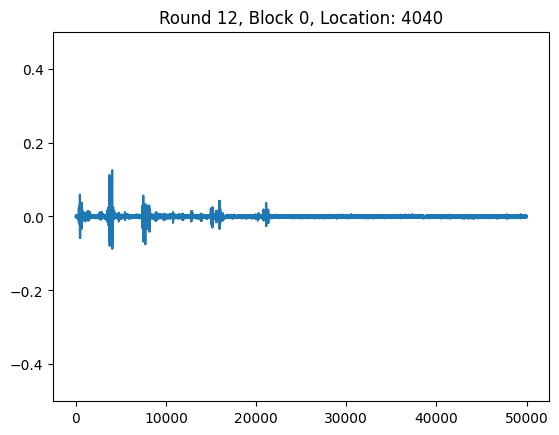

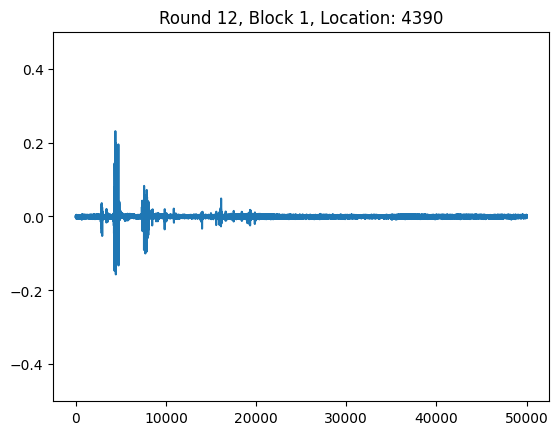

KeyboardInterrupt: 

In [25]:
for round_idx in range(len(correlation_locations), KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    corr_round = []
    for block_idx in range(BLOCK_WIDTH_B4):
        hyps = np.array([hypothesis_b4_rws_sboxes_location(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        corr_round.append(list(range(loc - 5, loc + 5)))
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()
    correlation_locations.append(corr_round)
correlation_locations = np.array(correlation_locations)

In [50]:
with open("correlation_locations_b4_two_last_rounds.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [36]:
with open("correlation_locations_b4_1000.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [20]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    key_space = (16,) if block_target_idx % 2 == 0 else (16, 16)
    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros(key_space + total_seeds.shape, dtype=int)

    if block_target_idx % 2 != 0:
        other_key_target_indices = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    for k in range(16):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k + whitening[keyround_target_idx]) % 16
                        sbox_out = s_boxes_b4[block_idx][block[block_idx]]

                        hypotheses[k][i] = HW[sbox_out]
                else:
                    for k1, k2 in product(range(16), range(16)):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k1 + whitening[keyround_target_idx]) % 16
                        block[block_idx - 1] = (k2 + whitening[keyround_target_idx - 1]) % 16
                        sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
                        
                        hypotheses[k1][k2][i] = HW[sbox_out]
                    other_key_target_indices[i] = indices[keyround_target_idx - 1]
        
                location_mask_per_trace[i][locations[round_idx][block_idx]] = True
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]
    
    if block_target_idx % 2 == 0:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]
    else:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)], other_key_target_indices

In [21]:
def indices_locations_and_hyps_to_use_for_each_key_nibble(key_target_idx: int, block_target_indices: set[int], total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    return [indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx, b, total_seeds, total_traces, locations) for b in block_target_indices]

Key 0: 

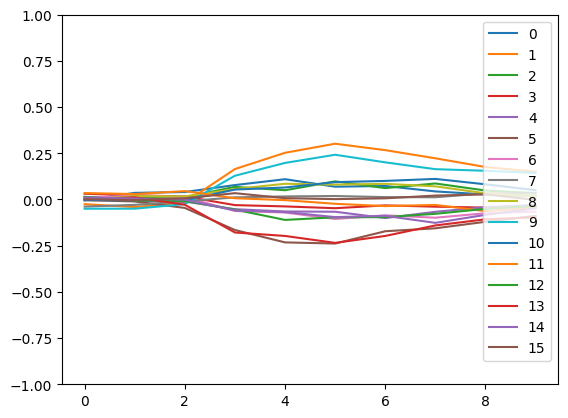

1[ 0.10960496  0.30169521  0.0980122   0.03098991  0.01305762 -0.00370739
  0.0223105   0.03311447  0.08503595  0.24201271  0.11129552  0.04535318
  0.01433394  0.0117986   0.01033939  0.03409246]


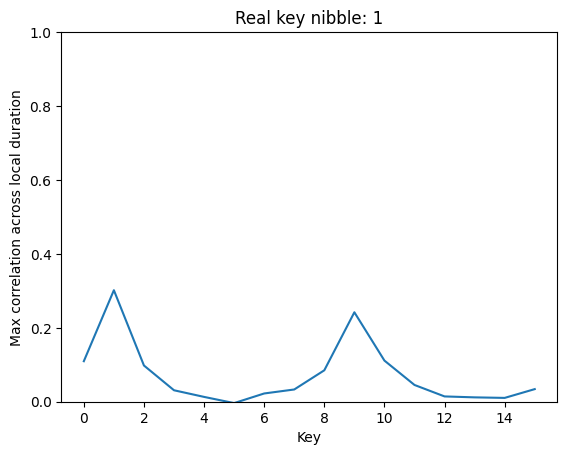

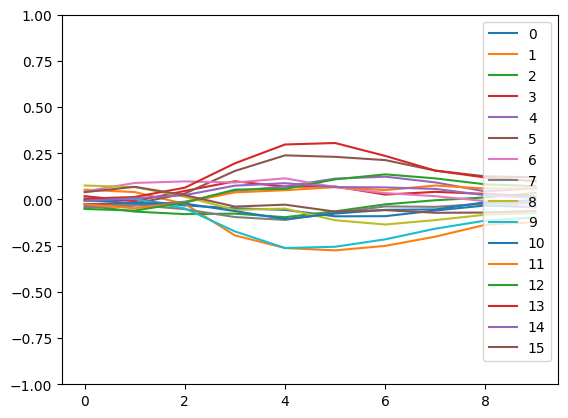

D[-0.00265111  0.05307226  0.0351219   0.0984216   0.12333685  0.23879073
  0.11441979 -0.0180418   0.07553938  0.00420295 -0.00381275  0.07554809
  0.13591009  0.30555221  0.08804267  0.06846279]


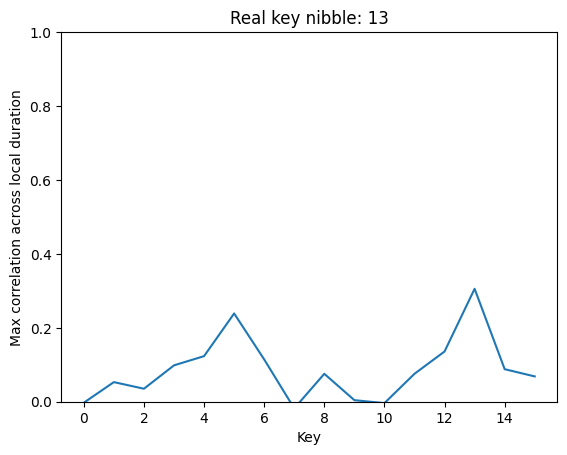

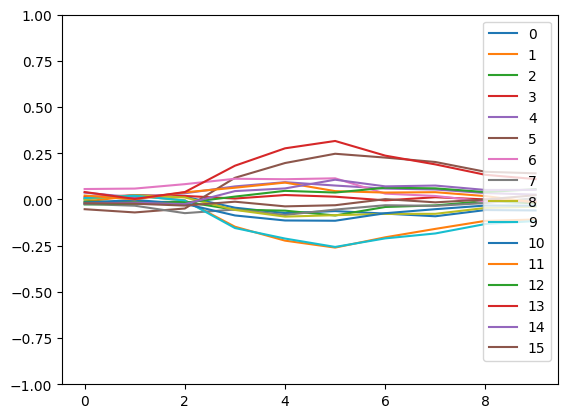

D[ 0.02254088  0.01994546 -0.0086752   0.02411288  0.09363553  0.24740633
  0.11449524  0.0074048   0.02231373  0.02002646 -0.00248637  0.09141479
  0.06339949  0.31657943  0.1069801   0.02326083]


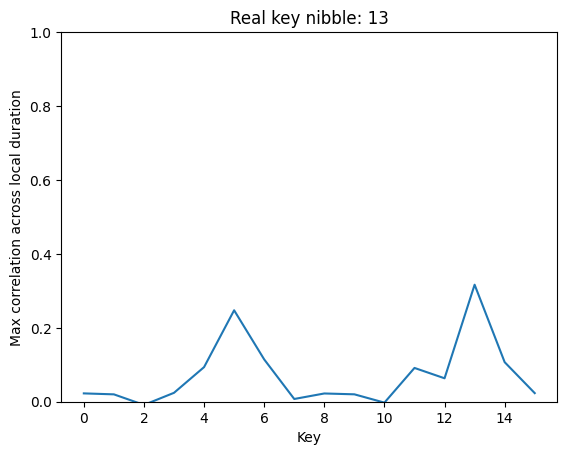

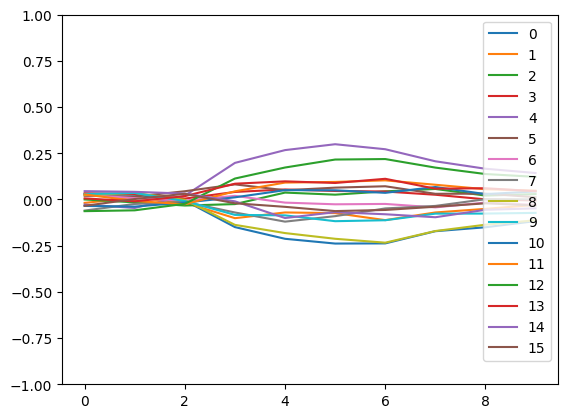

4[0.0298656  0.0097161  0.05688616 0.05412742 0.29897458 0.08164332
 0.02498855 0.00157304 0.03550914 0.03525849 0.06750767 0.10344576
 0.21876563 0.1119081  0.04507044 0.03057249]


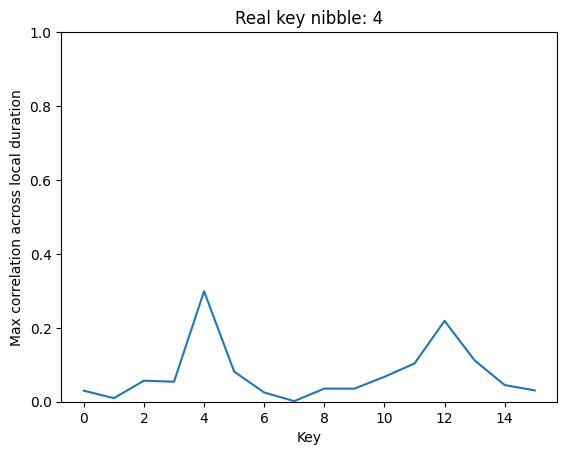

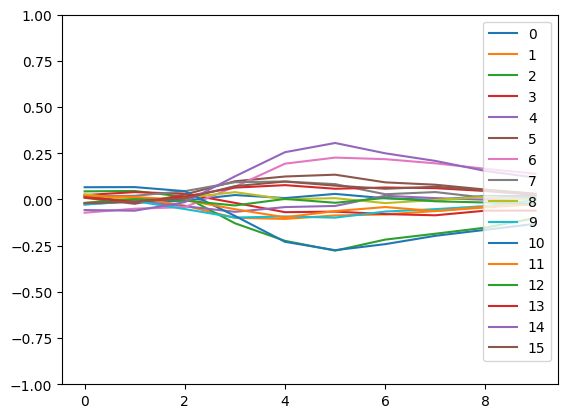

E[ 0.03020597  0.009912    0.04600146  0.03974734  0.019895    0.13416536
  0.22661733  0.09738415  0.03960059 -0.00432939  0.06696656  0.01834237
  0.00834547  0.07754588  0.30567401  0.09707563]


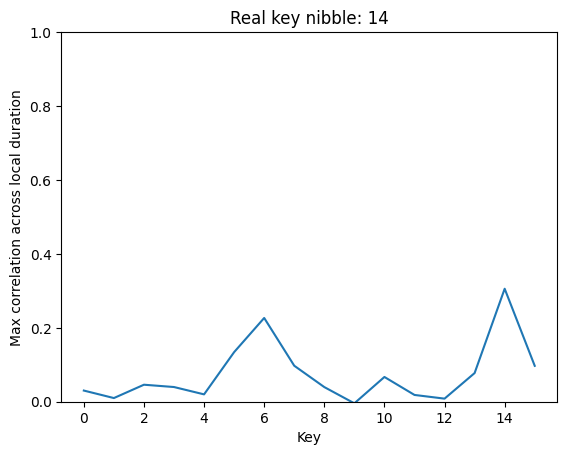

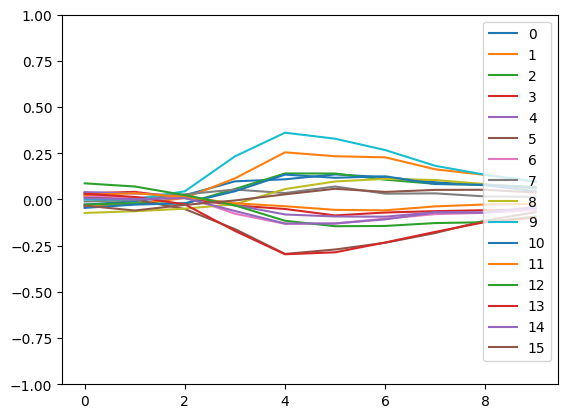

9[0.13550158 0.25511882 0.14085299 0.04108341 0.04026171 0.01424469
 0.02062162 0.07027258 0.11163811 0.36136253 0.13448855 0.03374638
 0.0873996  0.03068633 0.00742675 0.05788317]


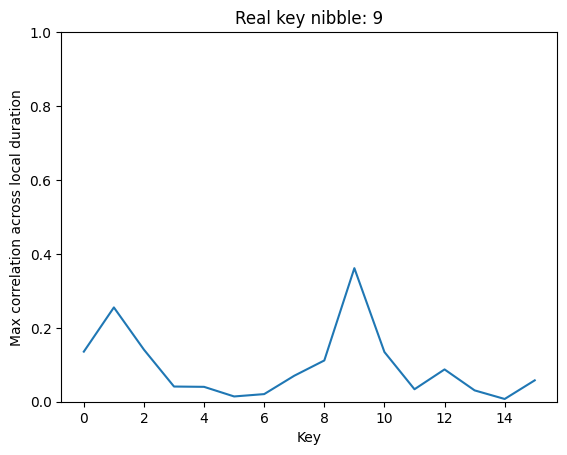

KeyboardInterrupt: 

In [26]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [4]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for k, block in enumerate(block_targets):
            if block % 2 == 0:
                selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
            else:
                selected_traces, hypotheses, other_key_indices = locs_and_hyps_per_block_target[k]

            corrs = np.array([corr_coef(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])
            for l in range(len(corrs)):
                plt.plot(corrs[l], label=str(l))

            plt.ylim([-1, 1])
            plt.legend()
            plt.show()
            
            max_corrs = np.max(corrs, axis=1)
            best_k = np.argmax(max_corrs)
            reconstructed_keys[i][j] = best_k

            if block % 2 != 0:
                pass
                #reconstructed_keys[i][other_key_indices[]]

            print(hex(best_k)[2:].upper(), end="")

            print(max_corrs)
            plt.plot(max_corrs)
            plt.xlabel("Key")
            plt.ylabel("Max correlation across local duration")
            plt.title(f"Real key nibble: {real_keys[i][j]}")
            plt.ylim([0, 1])
            plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()

In [15]:
def indices_locations_and_hyps_to_use_for_key_nibble(key_guess: List[int], key_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    seeds_indices = np.zeros_like(total_seeds, dtype=bool)
    location_mask_per_trace = np.zeros_like(total_traces, dtype=bool)
    hypotheses = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4
            locs = locations[round_idx][block_idx]

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != 4:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            seeds_indices[i] = True
            location_mask_per_trace[i][locs] = True

            block = [(key_guess[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    sbox_out = s_boxes_b4[block_idx][block[block_idx]]
                else:
                    raise ValueError("Should not happen")
                    sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
                hypotheses[i] = HW[sbox_out]
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]

    return seeds_indices, location_mask_per_trace, hypotheses[seeds_indices]

Key 0: 

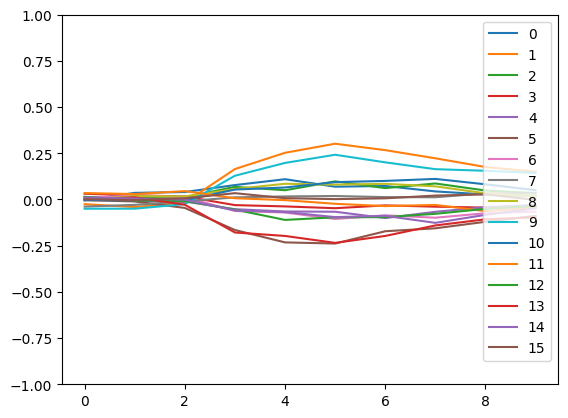

1[ 0.10960496  0.30169521  0.0980122   0.03098991  0.01305762 -0.00370739
  0.0223105   0.03311447  0.08503595  0.24201271  0.11129552  0.04535318
  0.01433394  0.0117986   0.01033939  0.03409246]


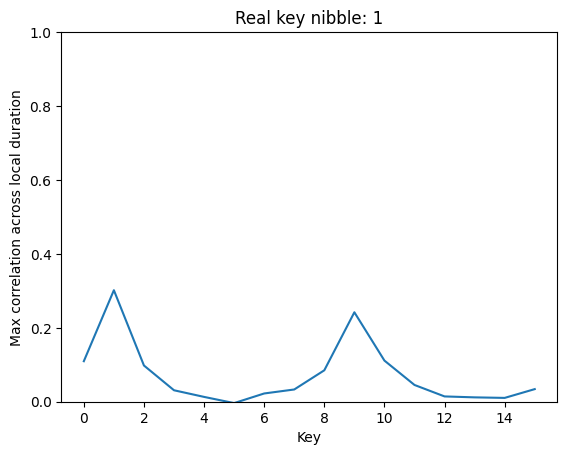

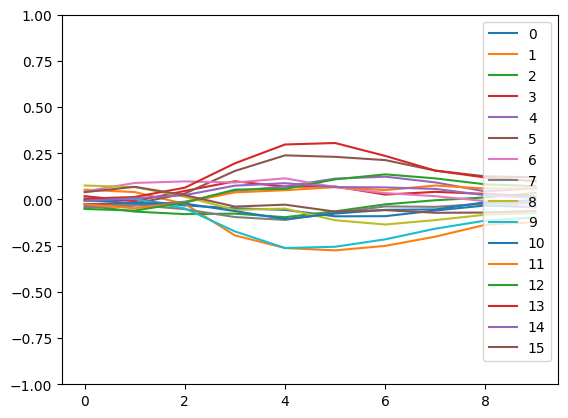

D[-0.00265111  0.05307226  0.0351219   0.0984216   0.12333685  0.23879073
  0.11441979 -0.0180418   0.07553938  0.00420295 -0.00381275  0.07554809
  0.13591009  0.30555221  0.08804267  0.06846279]


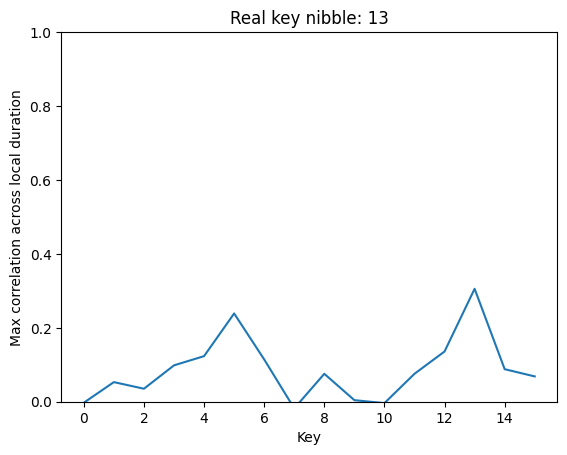

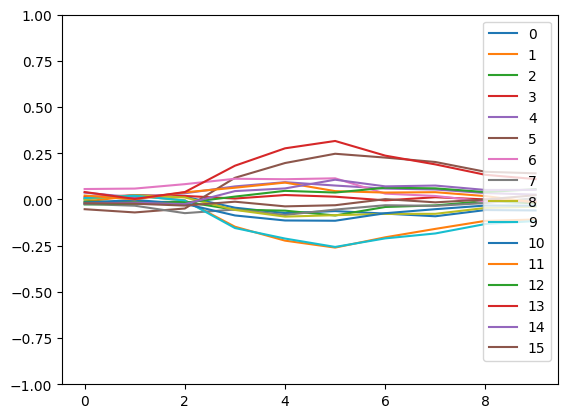

D[ 0.02254088  0.01994546 -0.0086752   0.02411288  0.09363553  0.24740633
  0.11449524  0.0074048   0.02231373  0.02002646 -0.00248637  0.09141479
  0.06339949  0.31657943  0.1069801   0.02326083]


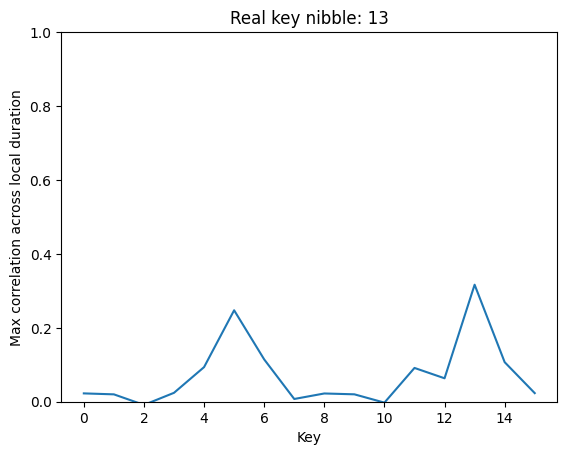

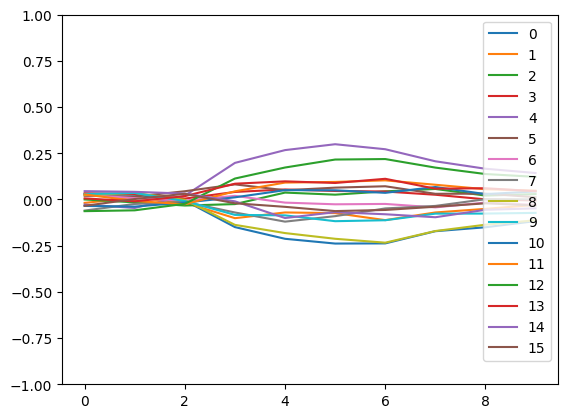

4[0.0298656  0.0097161  0.05688616 0.05412742 0.29897458 0.08164332
 0.02498855 0.00157304 0.03550914 0.03525849 0.06750767 0.10344576
 0.21876563 0.1119081  0.04507044 0.03057249]


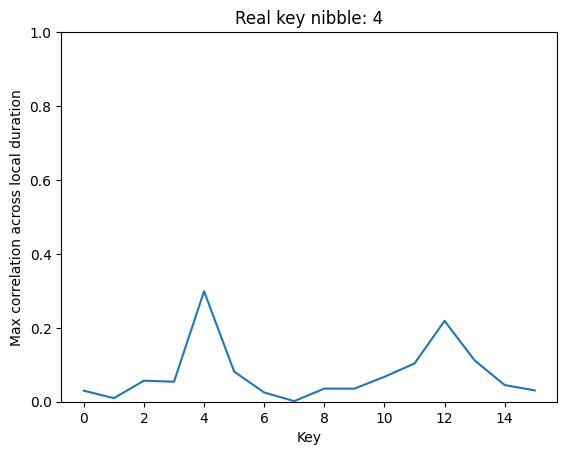

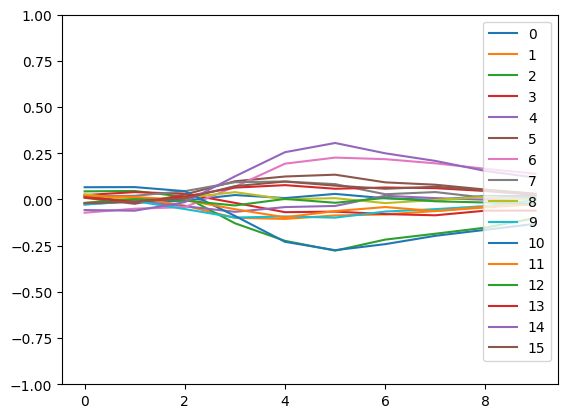

E[ 0.03020597  0.009912    0.04600146  0.03974734  0.019895    0.13416536
  0.22661733  0.09738415  0.03960059 -0.00432939  0.06696656  0.01834237
  0.00834547  0.07754588  0.30567401  0.09707563]


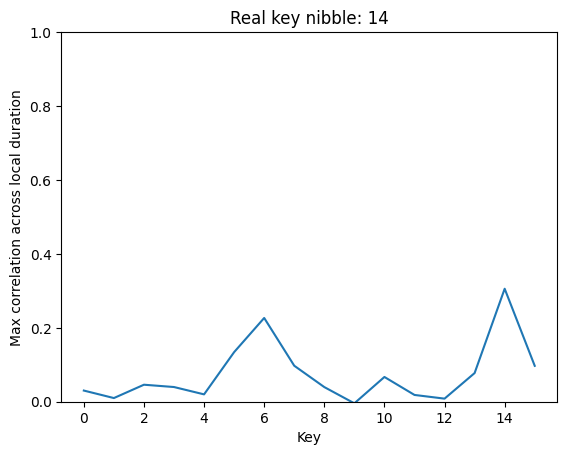

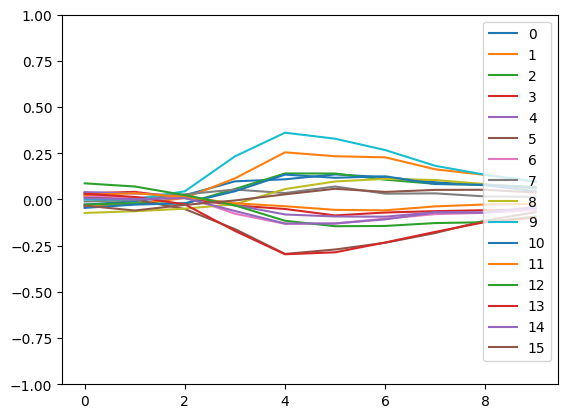

9[0.13550158 0.25511882 0.14085299 0.04108341 0.04026171 0.01424469
 0.02062162 0.07027258 0.11163811 0.36136253 0.13448855 0.03374638
 0.0873996  0.03068633 0.00742675 0.05788317]


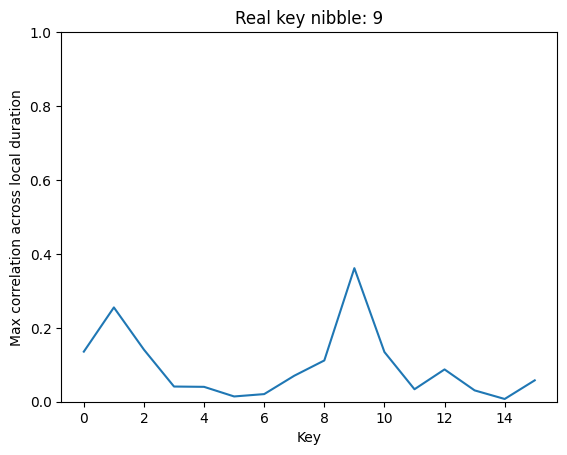

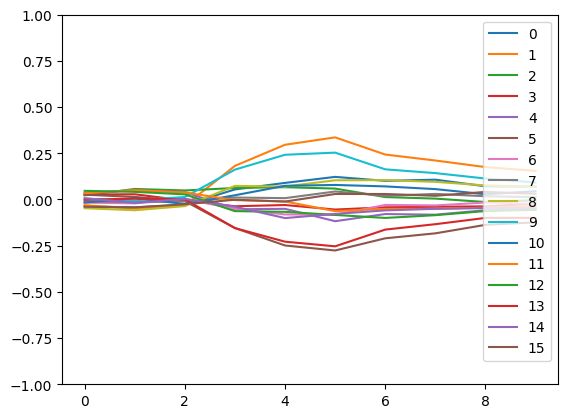

1[0.12227924 0.33607403 0.06636712 0.02822919 0.04973347 0.02585849
 0.00209629 0.04321974 0.10463704 0.25345225 0.07860054 0.05051387
 0.04663044 0.00533193 0.00697477 0.04101233]


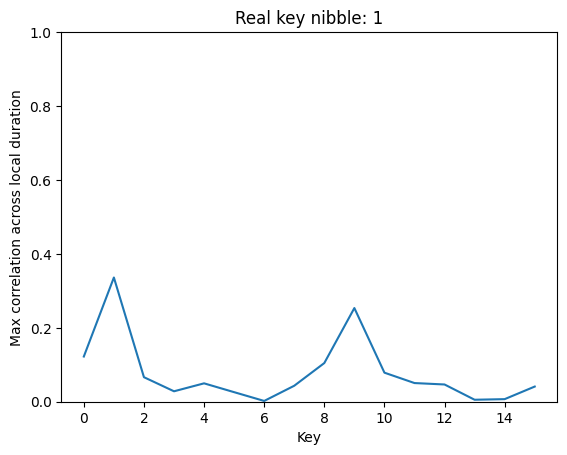

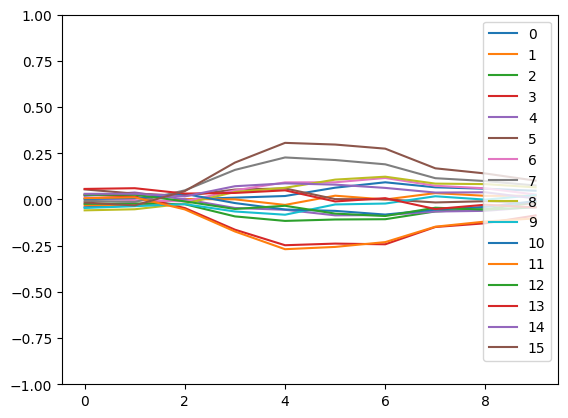

F[ 0.09299694  0.03446484 -0.01688982  0.02511179  0.03782386  0.05975373
  0.11632979  0.22737594  0.12329965  0.02347221  0.03008536  0.01167335
  0.02598681  0.06097685  0.08723961  0.30635674]


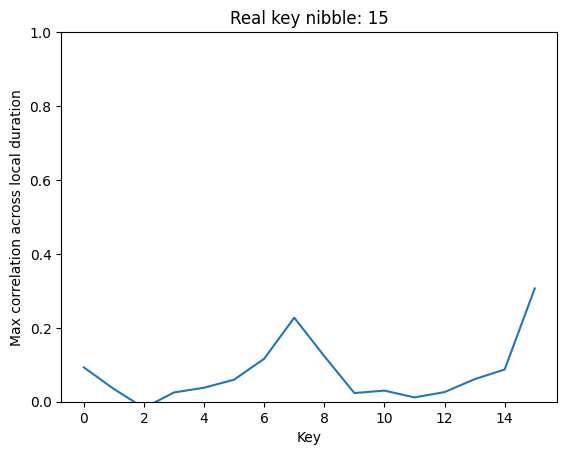

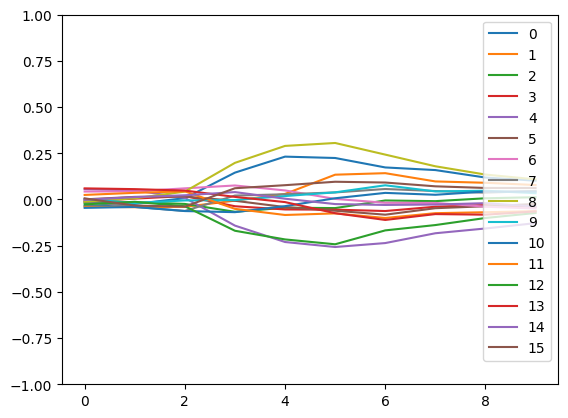

8[ 0.23185379  0.14235386  0.01216956  0.01825165  0.05578568  0.01582333
  0.07578601  0.0567005   0.30571076  0.07676069  0.04292301  0.04405784
 -0.01252     0.06012293  0.040004    0.09590971]


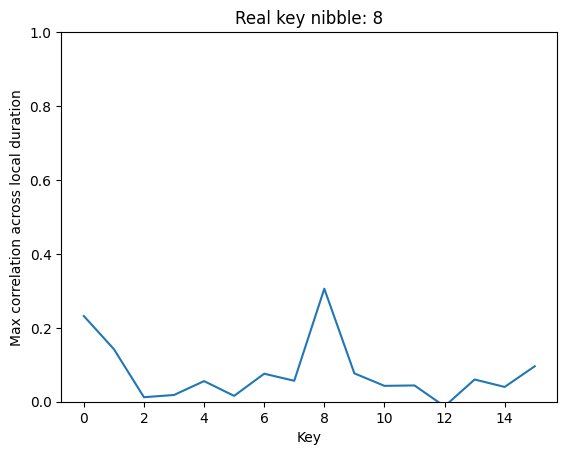

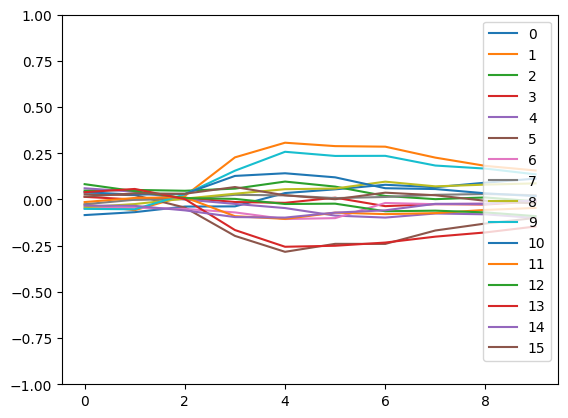

1[ 0.11295078  0.30716035  0.09694025  0.01419585  0.06057599  0.02848031
 -0.00734561  0.02961016  0.09643435  0.25808182  0.14180113  0.01203606
  0.0828796   0.05692389 -0.00399356  0.06730496]


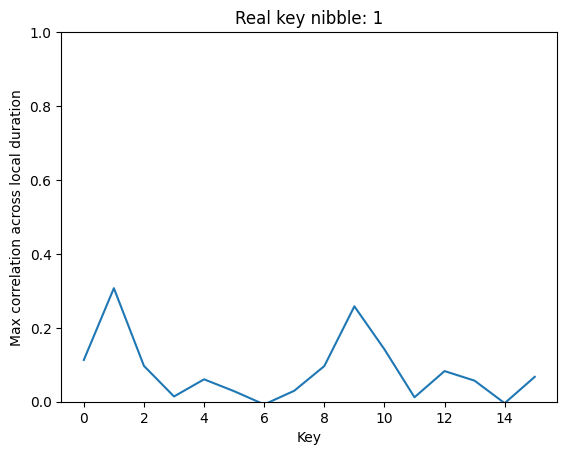

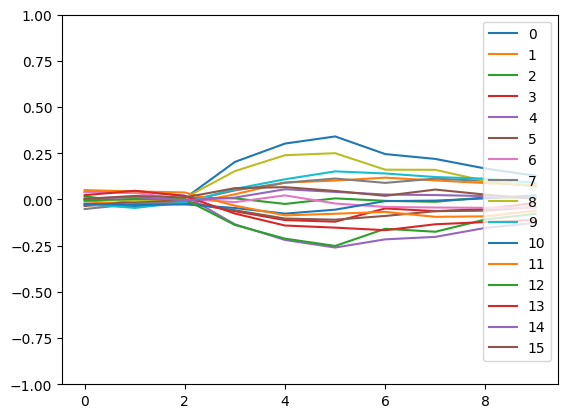

0[ 0.34109369  0.11801316  0.01652946  0.00161542  0.04587773 -0.01165852
  0.03891997  0.11334434  0.25041089  0.15203347  0.02229692  0.05079968
  0.00302301  0.04707354  0.0554033   0.06679857]


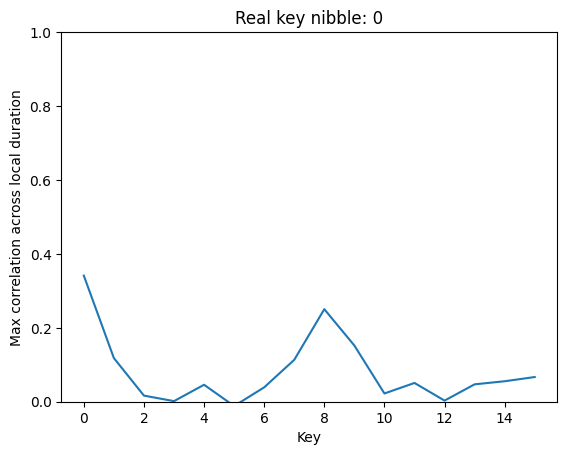

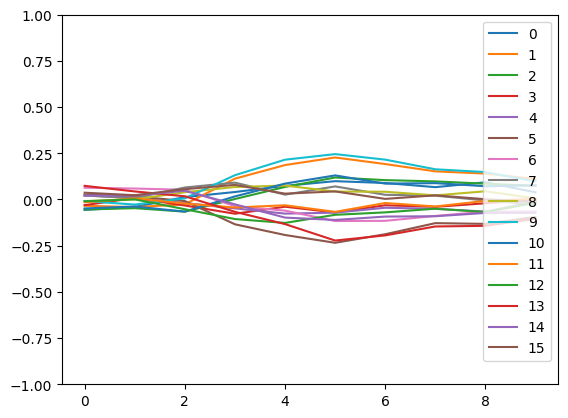

9[0.09908743 0.22728612 0.11889723 0.00796555 0.02222457 0.02649706
 0.06349816 0.09112919 0.07526511 0.24550218 0.13026301 0.00583095
 0.00060469 0.0737331  0.04694349 0.07902356]


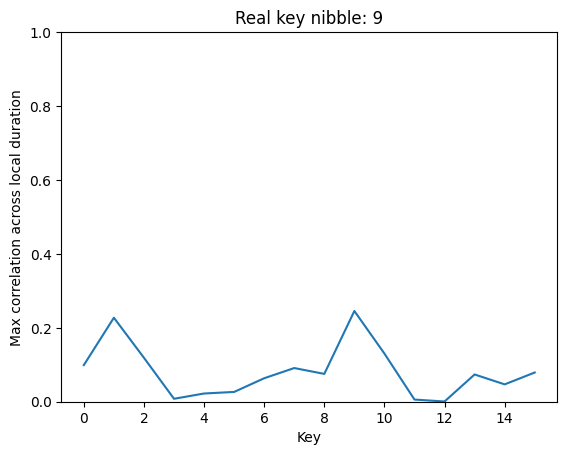

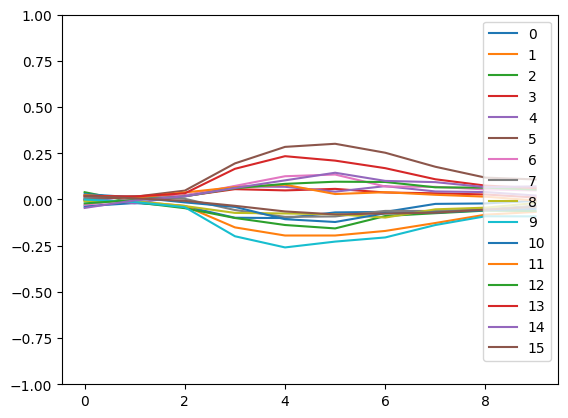

5[-0.00732272 -0.00620937  0.0394249   0.05736919  0.0722582   0.30140749
  0.13501223  0.01801263 -0.0082372  -0.00050666  0.02886964  0.07963015
  0.09614276  0.23425051  0.14472089  0.01978621]


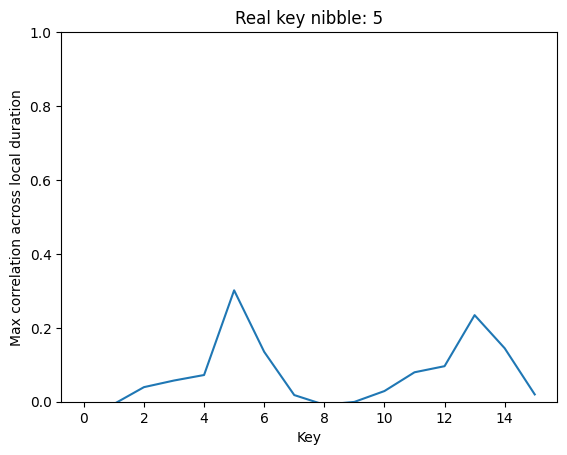

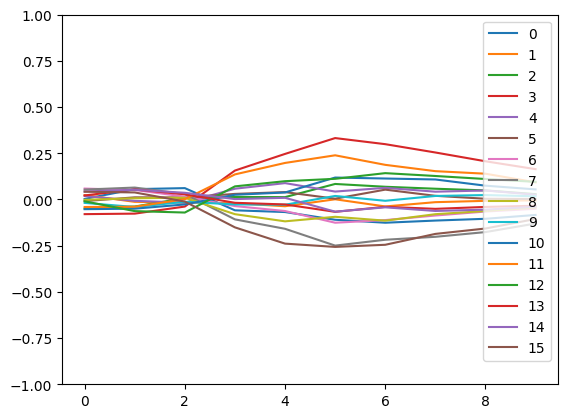

3[0.06146231 0.02359573 0.08396847 0.33227588 0.08848249 0.05327006
 0.05898604 0.06451488 0.00939344 0.02387284 0.11861039 0.23906897
 0.14248734 0.05412772 0.05243087 0.04207988]


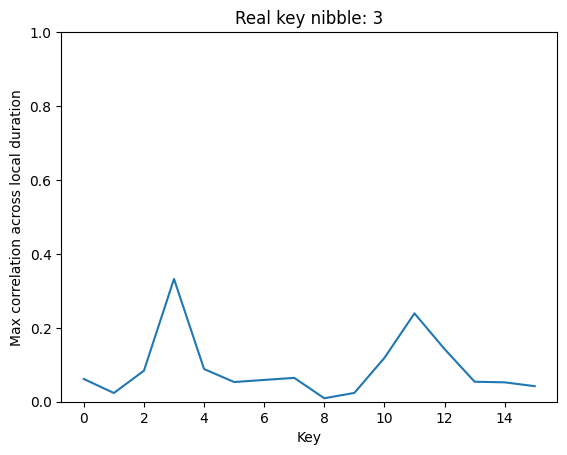

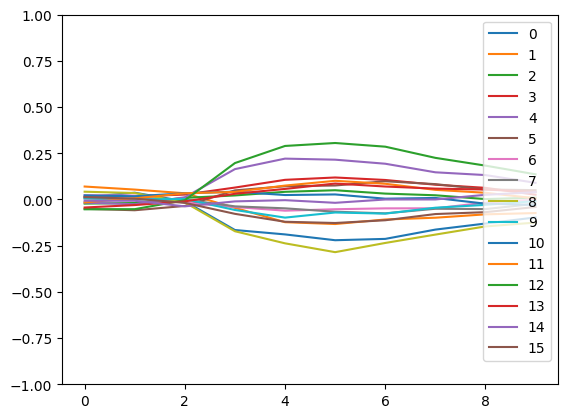

C[0.03657532 0.07005737 0.05000611 0.11901254 0.22106127 0.0986947
 0.02334849 0.00603515 0.04206863 0.00624766 0.04218163 0.10100234
 0.30560482 0.08632641 0.03965381 0.01249958]


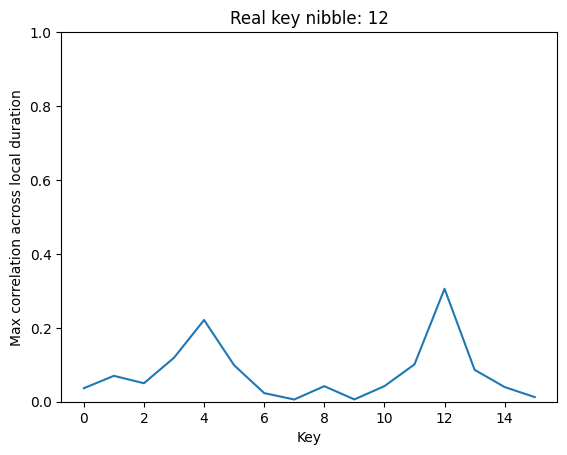

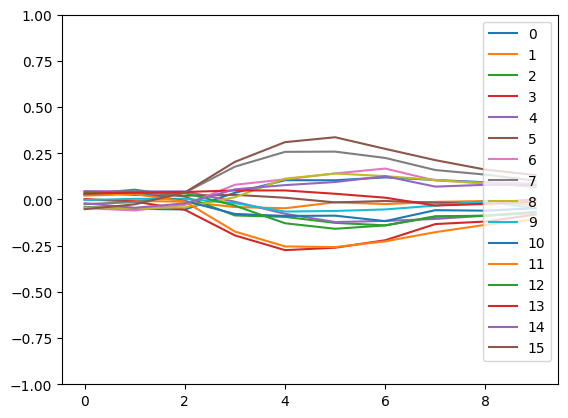

F[ 0.11957742 -0.00149824  0.05288334  0.00206712  0.04521578  0.03868607
  0.16734752  0.25898696  0.14050369  0.00352781  0.03336335  0.02932161
  0.03922901  0.04893396  0.12588609  0.33664786]


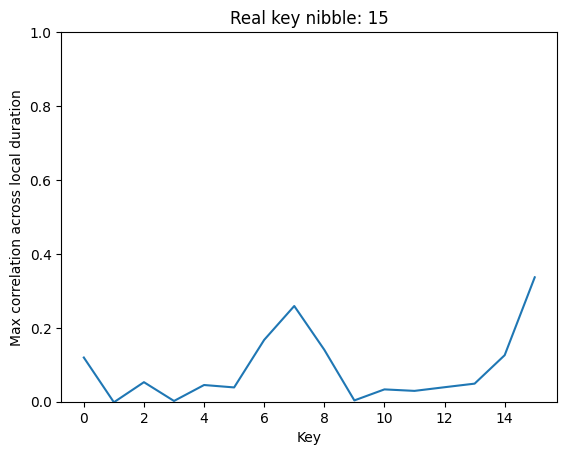

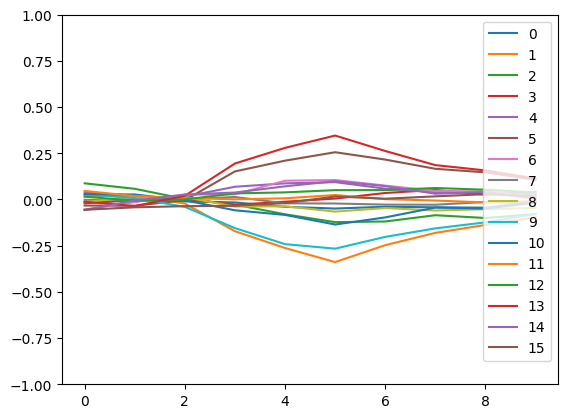

D[-0.00400915  0.02100001  0.08750603  0.05165962  0.09374778  0.25569704
  0.10519109  0.0133652   0.01356506  0.02804943  0.02917542  0.04620812
  0.06203325  0.34591683  0.09875221  0.0288379 ]


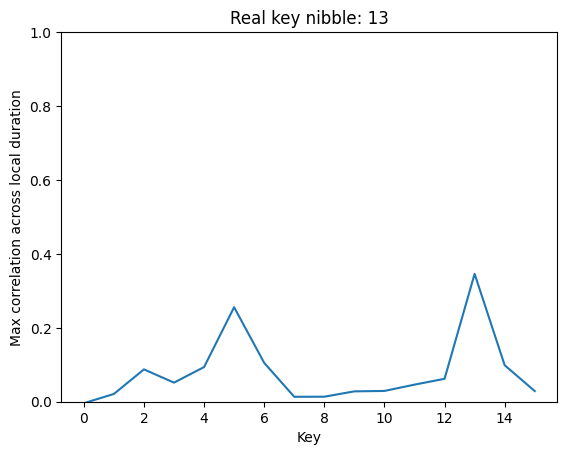

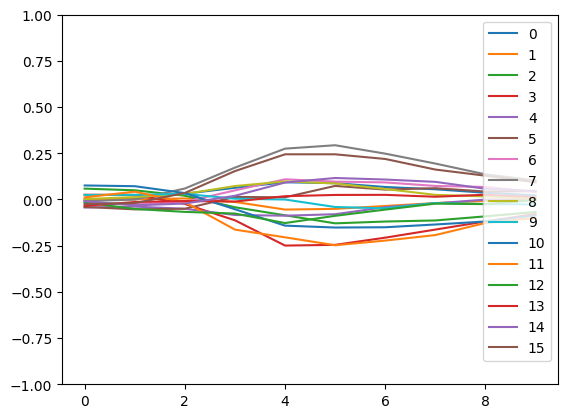

7[ 0.09323828  0.00546752  0.05873713  0.02560846  0.00044647  0.07341862
  0.10930196  0.29350814  0.09756641  0.03044031  0.0758155   0.04208873
 -0.00304685  0.02568036  0.11627757  0.24446706]


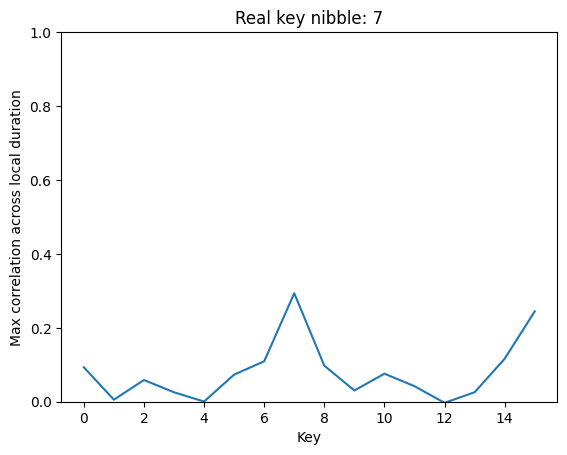

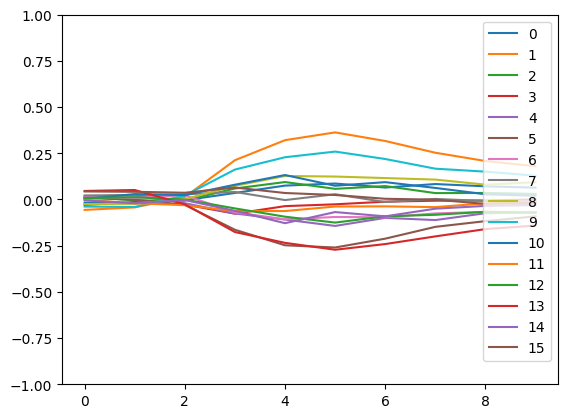

1[ 8.62874279e-02  3.63015516e-01  9.43038641e-02  2.81877225e-04
  2.21007762e-02  7.90957733e-03  2.24875148e-02  4.06785031e-02
  1.27133574e-01  2.59178339e-01  1.32254891e-01 -1.47165041e-03
  1.21659266e-02  5.12622532e-02 -3.02486312e-03  6.45829911e-02]


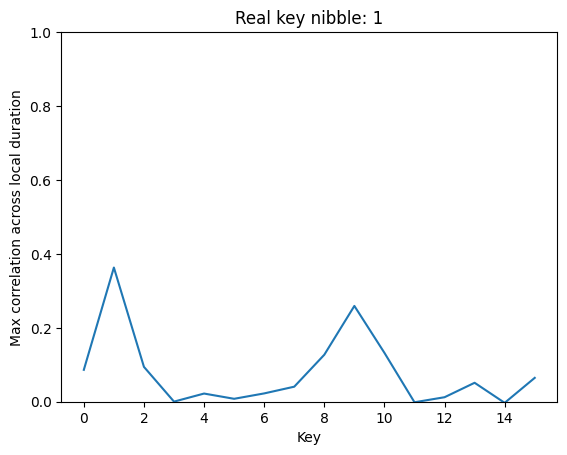

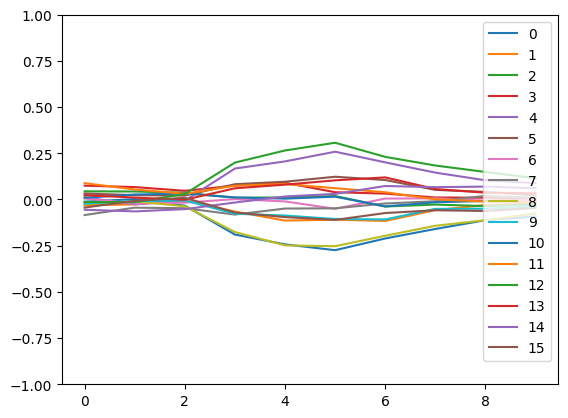

C[ 0.00207747 -0.00471559  0.04405845  0.09019962  0.25856728  0.12297753
  0.00623784  0.01948327 -0.00977893 -0.00552942  0.03211191  0.08842582
  0.30701326  0.11957677  0.07292514  0.00900212]


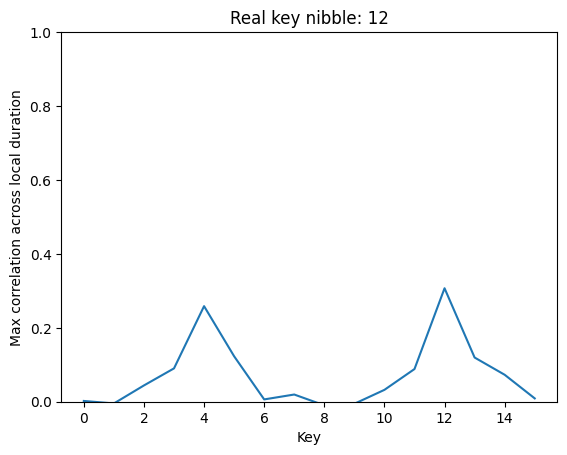

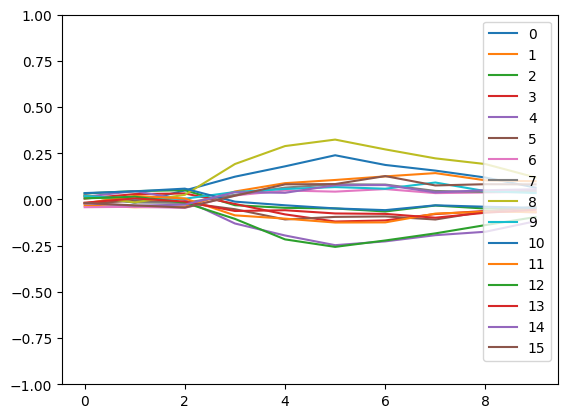

8[ 0.23926232  0.14270443  0.05021024  0.03263669  0.04545848 -0.00737347
  0.05627933  0.08222265  0.32408247  0.09179396  0.05867924  0.01920829
  0.01498638  0.00552902  0.07806906  0.12658855]


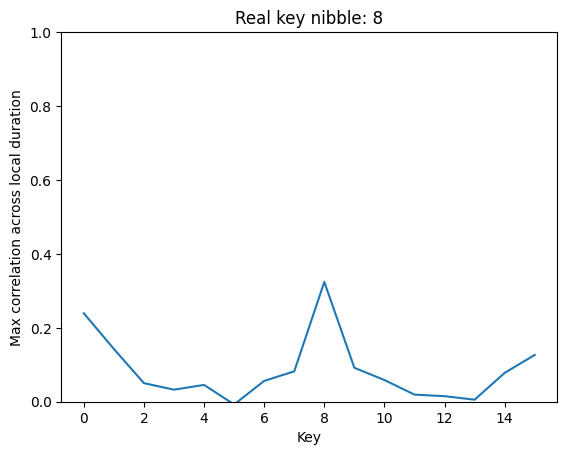

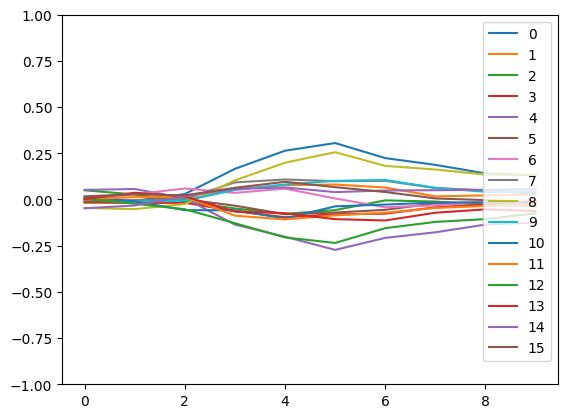

0[ 0.30538122  0.08084329  0.04979393 -0.00720358  0.05669915  0.00092643
  0.05933474  0.10817371  0.25577651  0.10549611  0.01373408  0.01547255
  0.00552952  0.03639374  0.06493368  0.09571856]


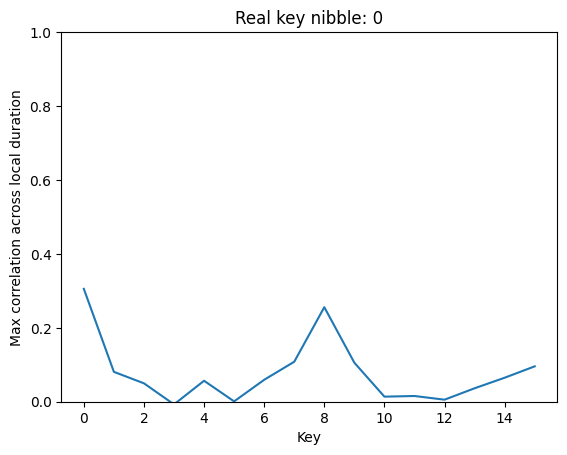

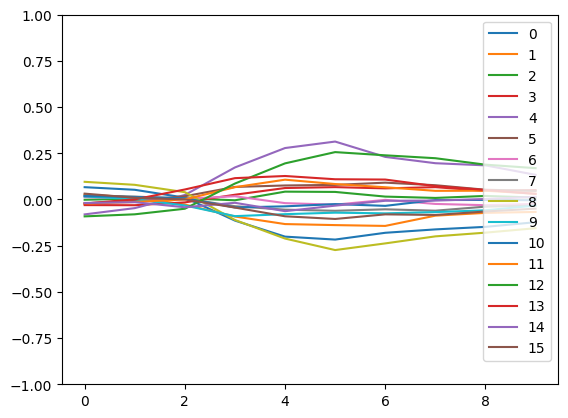

4[0.06657217 0.02638925 0.04237586 0.06685437 0.31338463 0.09104611
 0.01741236 0.02197488 0.09556371 0.01648096 0.01851647 0.1071415
 0.25633456 0.12705705 0.01427503 0.031634  ]


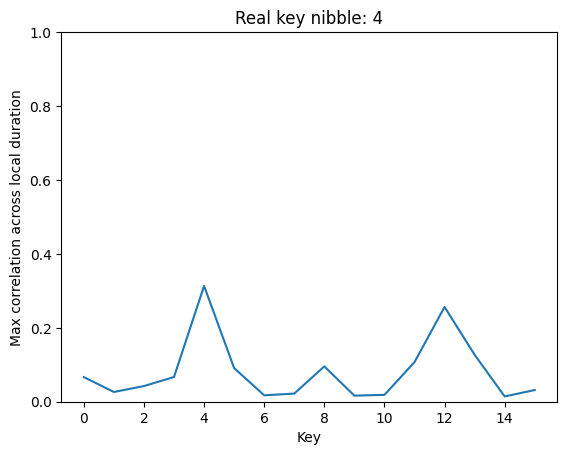

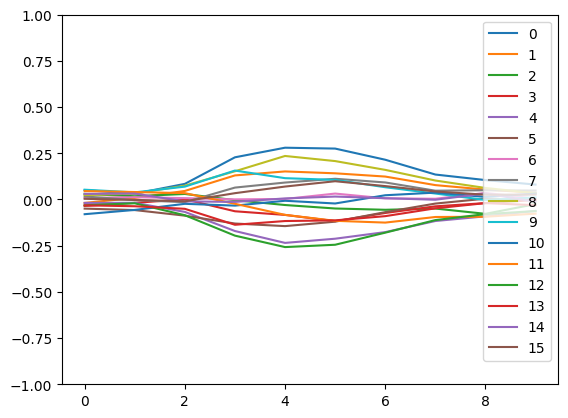

0[ 0.28014222  0.15177204  0.03008301  0.00113897 -0.01797925  0.00433008
  0.03548944  0.11205642  0.23543916  0.15646919  0.0371055   0.04547139
 -0.02061887 -0.00236152  0.03245594  0.09875502]


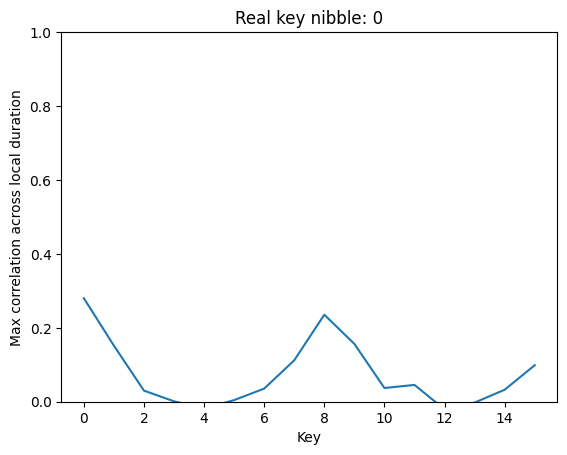

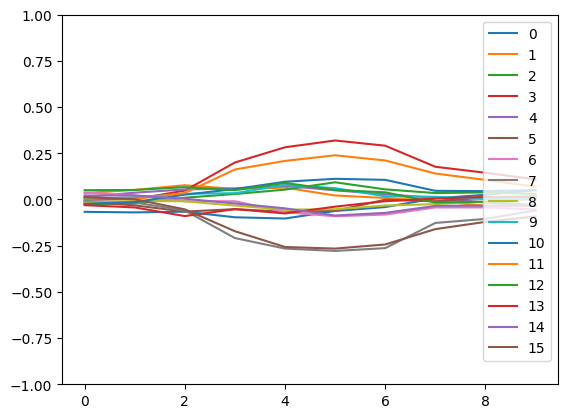

3[ 0.05092968  0.07703556  0.09305332  0.31921333  0.07388684  0.01638559
  0.03791757 -0.00874872  0.00209347  0.07912889  0.11190837  0.23914095
  0.08946712  0.01486758  0.02155955  0.01254425]


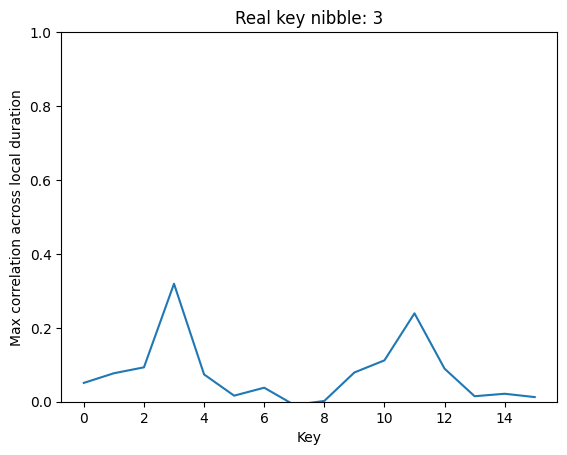

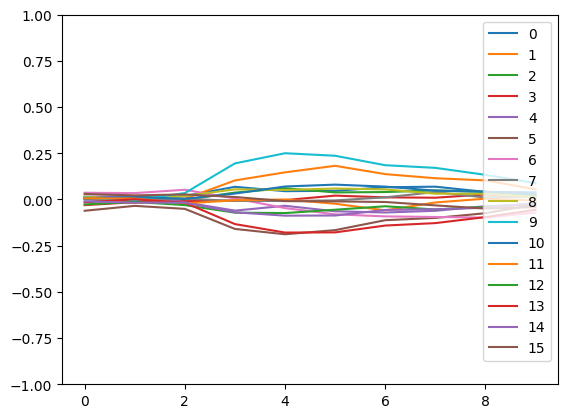

9[ 0.06930913  0.18219962  0.06063971  0.02738263  0.01772815 -0.02737166
  0.05255991  0.04007065  0.05924155  0.25025372  0.08035553  0.00685623
 -0.01337337  0.00124572 -0.01034816  0.02985124]


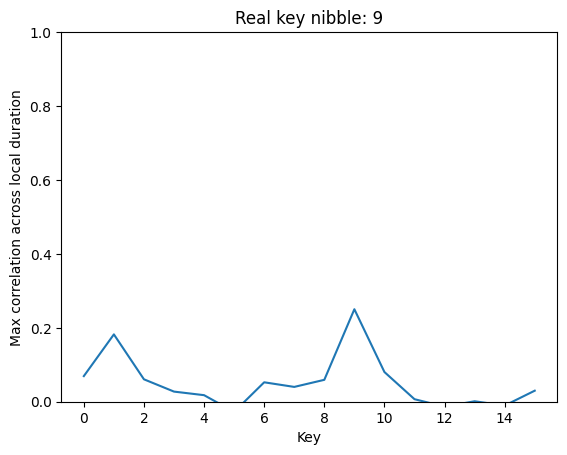

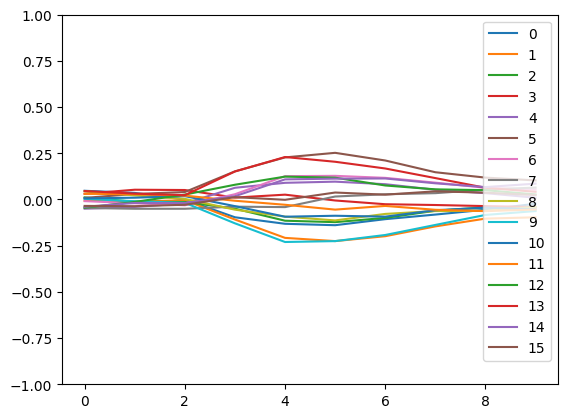

5[ 0.04705609 -0.00406966  0.01132071  0.05279825  0.09644671  0.25242816
  0.12789486  0.06440443  0.04485095  0.00359773  0.01812872  0.0305889
  0.12364433  0.22971586  0.11360931  0.04414686]


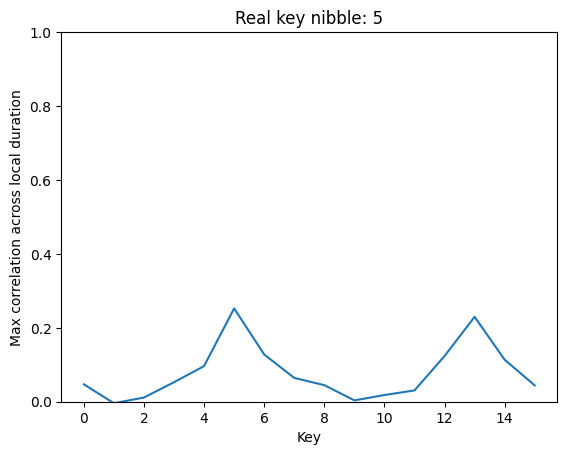

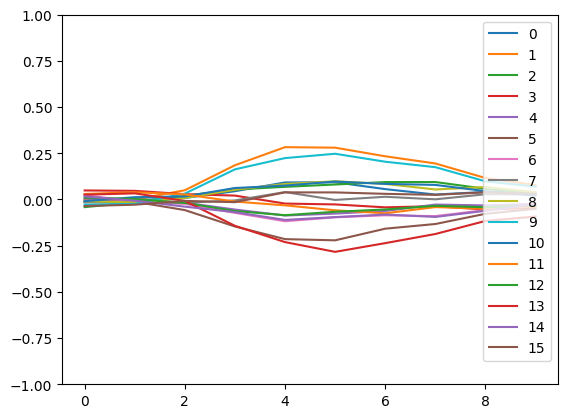

1[ 0.09312251  0.28314349  0.09435248  0.04883338  0.00270558 -0.01220016
  0.02319883  0.04006884  0.09857627  0.24736706  0.09703707  0.03900639
  0.01097606  0.03309493  0.01679079  0.03882144]


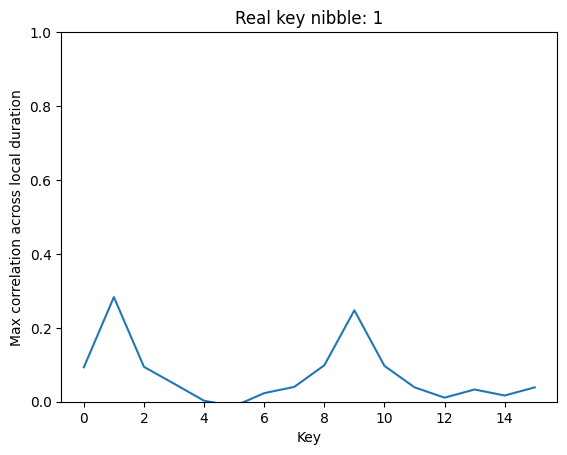

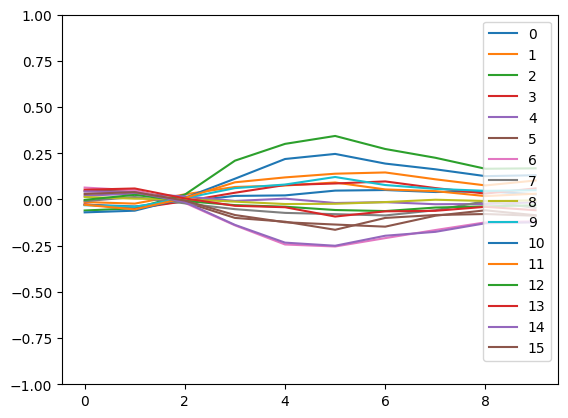

2[0.05115782 0.09183798 0.34374745 0.09771211 0.03198512 0.04842122
 0.06447447 0.01348956 0.01366412 0.12162927 0.24651717 0.14623885
 0.02497132 0.0595427  0.04341874 0.03981308]


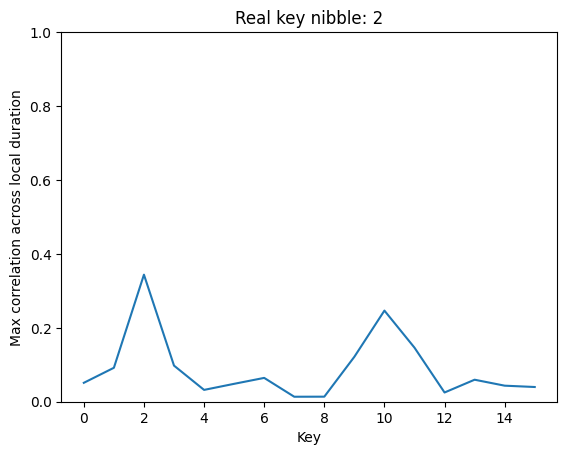

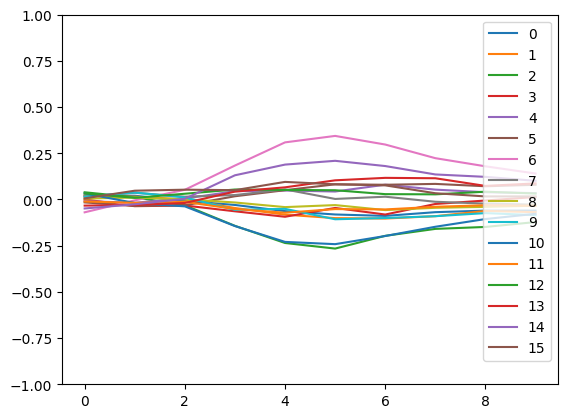

6[ 0.02064071  0.02144725  0.038985    0.01354007  0.08003905  0.08427189
  0.34397683  0.05439466  0.01033788  0.03772346  0.0325388  -0.01088389
  0.05393138  0.11698636  0.20917872  0.09516035]


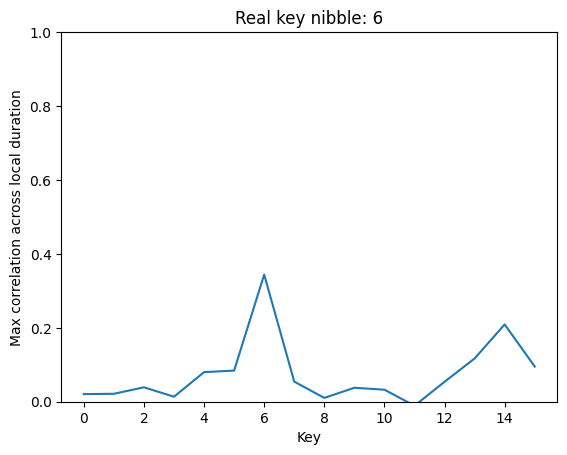

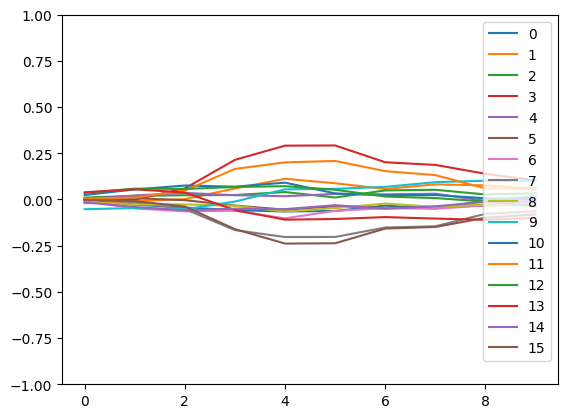

3[ 0.0168845   0.11191849  0.05246349  0.29229981  0.03551231  0.00713339
 -0.00913449  0.00593007 -0.0156808   0.10130503  0.09105984  0.20847566
  0.07184984  0.05499926 -0.01217345 -0.0022649 ]


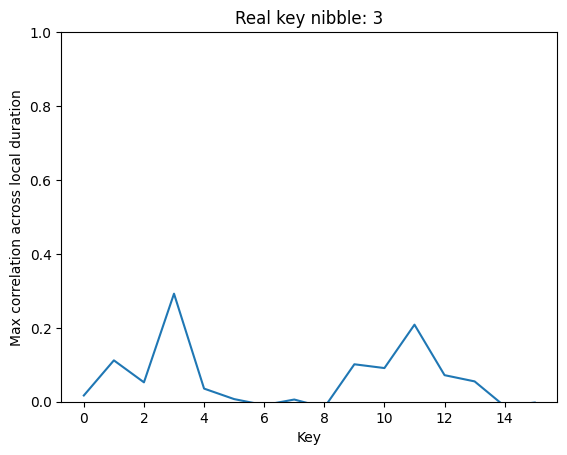

7

KeyboardInterrupt: 

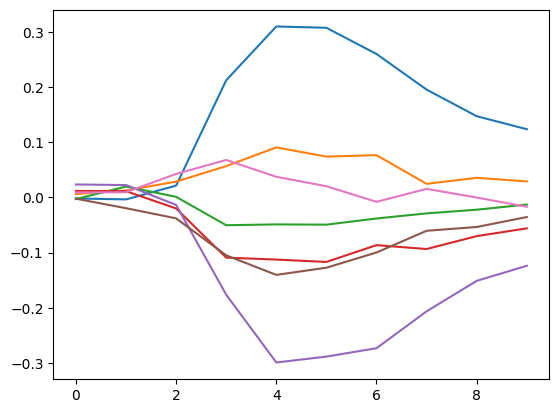

In [16]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    for j in range(reconstructed_keys.shape[1]):
        max_corrs = np.empty(16)

        for k in range(16):
            print(hex(k)[2:].upper(), end="")
            reconstructed_keys[i][j] = k

            indices, location_masks, hypotheses = indices_locations_and_hyps_to_use_for_key_nibble(reconstructed_keys[i], j, seeds[i], traces[i], correlation_locations)#np.array([[list(range(correlation_locations[i][j][5] - 25, correlation_locations[i][j][5] + 25)) for j in range(correlation_locations.shape[1])] for i in range(correlation_locations.shape[0])]))

            selected_seeds = seeds[i][indices]
            selected_traces = traces[i][location_masks].reshape((selected_seeds.shape[0], correlation_locations.shape[2]))

            corr = corr_coef(hypotheses, selected_traces)

            plt.plot(corr, label=str(k))

            #max_corrs[k] = np.max(np.abs(corr))
            max_corrs[k] = np.max(corr)
            print("\b", end="")

        plt.ylim([-1, 1])
        plt.legend()
        plt.show()

        best_k = np.argmax(max_corrs)
        reconstructed_keys[i][j] = best_k
        print(hex(best_k)[2:].upper(), end="")

        print(max_corrs)
        plt.plot(max_corrs)
        plt.xlabel("Key")
        plt.ylabel("Max correlation across local duration")
        plt.title(f"Real key nibble: {real_keys[i][j]}")
        plt.ylim([0, 1])
        plt.show()

    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()